# Sentiment Analysis with DistilBERT - Local CSV Dataset

In this notebook, we'll implement a complete workflow for fine-tuning a pre-trained language model (DistilBERT) on the IMDB Movie Reviews dataset for sentiment classification, using a local CSV file rather than the Hugging Face dataset.

## Steps:
1. Install required libraries
2. Load the local IMDB dataset CSV file
3. Extensive data preprocessing and cleaning
4. Split into training, validation, and test sets
5. Tokenize the text
6. Fine-tune DistilBERT for sentiment classification
7. Save the model
8. Create a prediction function for new reviews

## 1. Install Required Libraries

Let's install the necessary packages for our sentiment analysis project:

In [10]:
# Install required packages
!pip install -q transformers torch scikit-learn pandas matplotlib nltk wordcloud tqdm opendatasets

## 2. Import Libraries

Now, let's import all the libraries we'll need for our data preparation and model training:

In [11]:
import torch
import pandas as pd
import numpy as np
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from collections import Counter
import opendatasets as od

# For text preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

# For model training and evaluation
from transformers import (
    DistilBertTokenizer,
    DistilBertForSequenceClassification,
    TrainingArguments,
    Trainer
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

# For progress tracking
from IPython.display import display, HTML

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Download necessary NLTK resources
try:
    nltk.download('punkt', quiet=True)
    nltk.download('stopwords', quiet=True)
    nltk.download('wordnet', quiet=True)
    print("NLTK resources downloaded successfully!")
except:
    print("Warning: Unable to download NLTK resources. Some text preprocessing features may not work.")

NLTK resources downloaded successfully!


## 3. Check for GPU Availability

Let's check if we have GPU support to speed up our training:

In [12]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if device.type == "cuda":
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"Total GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1024 ** 3:.2f} GB")
else:
    print("No GPU available, using CPU. Training will be slower.")

Using device: cuda
GPU Name: Tesla T4
Total GPU memory: 14.74 GB


In [13]:
#You should enter you kaggle username and tokken
od.download("https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")


Skipping, found downloaded files in "./imdb-dataset-of-50k-movie-reviews" (use force=True to force download)


## 4. Load and Explore the Local IMDB Dataset

Now we'll load the dataset from the local CSV file and explore its structure:

In [14]:
# Define the path to the IMDB dataset CSV file
csv_path = "/content/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv"

# Function to check if the file exists and handle errors
def load_csv_dataset(path):
    try:
        if os.path.exists(path):
            df = pd.read_csv(path)
            print(f"✅ Dataset loaded successfully from {path}")
            print(f"   Shape: {df.shape}")
            return df
        else:
            # Check if we need to mount Google Drive (for Colab)
            if path.startswith("/content"):
                print(f"⚠️ File not found at {path}")
                print("If you're using Google Colab, you might need to:")
                print("1. Upload the dataset to Colab; or")
                print("2. Mount Google Drive if the dataset is stored there.")

                # Code to mount Google Drive if needed
                print("\nWould you like to mount Google Drive? (Uncomment the code below if needed)")
                print("```python")
                print("from google.colab import drive")
                print("drive.mount('/content')")
                print("```")

                # Check other common locations
                alternative_paths = [
                    "/content/IMDB Dataset.csv",
                    "./IMDB Dataset.csv",
                    "/content/drive/MyDrive/IMDB Dataset.csv",
                    "/content/sample_data/IMDB Dataset.csv"
                ]

                for alt_path in alternative_paths:
                    if os.path.exists(alt_path):
                        print(f"\n✅ Dataset found at alternative location: {alt_path}")
                        return pd.read_csv(alt_path)

            raise FileNotFoundError(f"Dataset file not found at {path}")

    except pd.errors.ParserError as e:
        print(f"❌ Error parsing CSV file: {e}")
        print("This might be due to corruption or incorrect format.")
        raise
    except Exception as e:
        print(f"❌ Error loading dataset: {type(e).__name__}: {e}")
        raise

# Try to load the dataset
try:
    imdb_df = load_csv_dataset(csv_path)
except FileNotFoundError:
    print("\n⚠️ Please upload the IMDB Dataset.csv file to the specified location.")
    print("For now, creating a small sample dataset for demonstration purposes.")

    # Create a tiny sample dataset for demonstration in case file isn't found
    imdb_df = pd.DataFrame({
        'review': [
            "This movie was excellent! I loved every minute of it.",
            "Terrible film, waste of money and time.",
            "Pretty good movie, though a bit slow in parts.",
            "Absolutely hated it, the worst movie I've seen this year."
        ],
        'sentiment': ['positive', 'negative', 'positive', 'negative']
    })
    print("✅ Sample dataset created for demonstration.")

✅ Dataset loaded successfully from /content/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv
   Shape: (50000, 2)


## 5. Explore the Dataset

Let's examine the dataset to understand its structure and characteristics:

Dataset Overview:
Number of reviews: 50000
Columns: review, sentiment

Missing values per column:
review       0
sentiment    0
dtype: int64

Sentiment distribution:
sentiment
positive    25000
negative    25000
Name: count, dtype: int64
Class balance: 100.00% (closer to 100% is better)

Sample reviews:

Example 1 (positive):
One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me abo...

Example 2 (positive):
A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece...

Example 3 (positive):
I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is wi...

Review length

<ipython-input-15-e449673f05af>:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment', data=imdb_df, palette=['coral', 'lightblue'])


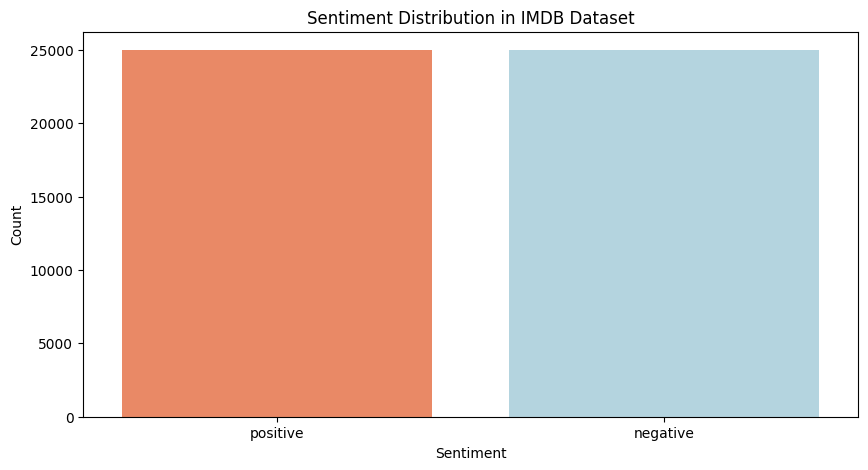

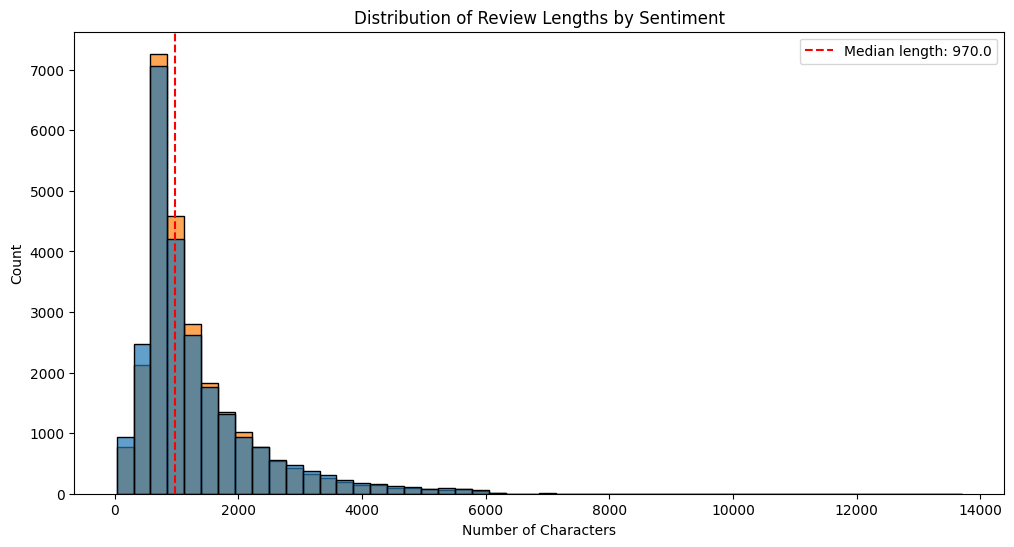

In [15]:
# Check basic information about the dataset
print("Dataset Overview:")
print(f"Number of reviews: {len(imdb_df)}")
print(f"Columns: {', '.join(imdb_df.columns)}")

# Check for missing values
missing_values = imdb_df.isnull().sum()
print("\nMissing values per column:")
print(missing_values)

# Display sentiment distribution
sentiment_counts = imdb_df['sentiment'].value_counts()
print("\nSentiment distribution:")
print(sentiment_counts)

# Class balance percentage
balance = min(sentiment_counts) / max(sentiment_counts) * 100
print(f"Class balance: {balance:.2f}% (closer to 100% is better)")

# Display a few examples
print("\nSample reviews:")
for i, (review, sentiment) in enumerate(zip(imdb_df['review'].head(3), imdb_df['sentiment'].head(3))):
    print(f"\nExample {i+1} ({sentiment}):")
    print(f"{review[:200]}..." if len(review) > 200 else review)

# Review length statistics
imdb_df['review_length'] = imdb_df['review'].apply(len)
print("\nReview length statistics:")
print(imdb_df['review_length'].describe())

# Visualize sentiment distribution
plt.figure(figsize=(10, 5))
sns.countplot(x='sentiment', data=imdb_df, palette=['coral', 'lightblue'])
plt.title('Sentiment Distribution in IMDB Dataset')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

# Visualize review length distribution
plt.figure(figsize=(12, 6))
sns.histplot(data=imdb_df, x='review_length', hue='sentiment', bins=50, alpha=0.7)
plt.title('Distribution of Review Lengths by Sentiment')
plt.xlabel('Number of Characters')
plt.ylabel('Count')
plt.axvline(x=imdb_df['review_length'].median(), color='r', linestyle='--',
           label=f'Median length: {imdb_df["review_length"].median()}')
plt.legend()
plt.show()

## 6. Text Preprocessing and Cleaning

Now we'll create a comprehensive text preprocessing pipeline to clean and normalize our review text:

1. Convert text to lowercase
2. Remove HTML tags and URLs
3. Remove special characters and numbers
4. Remove extra whitespace
5. Remove stopwords (optional)
6. Lemmatization (optional)

Applying basic preprocessing to all reviews...


100%|██████████| 50000/50000 [00:06<00:00, 7503.10it/s]



Original vs Processed Examples:

Example 1:
Original: One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with...
Processed: one of the other reviewers has mentioned that after watching just oz episode youll be hooked they are right as this is exactly what happened with meth...

Example 2:
Original: A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes d...
Processed: a wonderful little production the filming technique is very unassuming very oldtimebbc fashion and gives a comforting and sometimes discomforting sens...

Example 3:
Original: I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted come...
Processed: i thought this was a wonderful way to spend time on a too hot summer weekend sitting in the air co

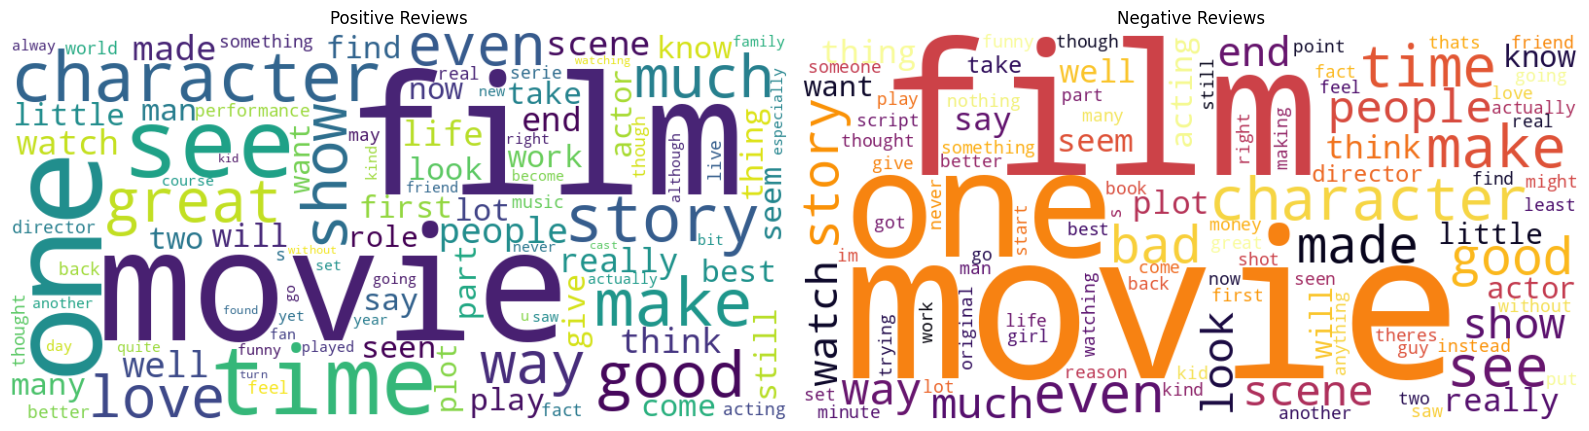

In [16]:
from tqdm import tqdm
tqdm.pandas()
# Define our text preprocessing function with multiple steps
def preprocess_text(text, remove_stopwords=False, lemmatize=False):
    """
    Preprocess text data with configurable options

    Args:
        text (str): Text to preprocess
        remove_stopwords (bool): Whether to remove stopwords
        lemmatize (bool): Whether to apply lemmatization

    Returns:
        str: Preprocessed text
    """
    # Convert to lowercase
    text = text.lower()

    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)

    # Remove special characters and numbers (keep only letters and spaces)
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    # Optional advanced preprocessing
    if remove_stopwords or lemmatize:
        # Tokenize
        tokens = word_tokenize(text)

        # Remove stopwords if requested
        if remove_stopwords:
            stop_words = set(stopwords.words('english'))
            tokens = [word for word in tokens if word not in stop_words]

        # Lemmatize if requested
        if lemmatize:
            lemmatizer = WordNetLemmatizer()
            tokens = [lemmatizer.lemmatize(word) for word in tokens]

        # Join tokens back to string
        text = ' '.join(tokens)

    return text

# Let's apply basic preprocessing to all reviews
print("Applying basic preprocessing to all reviews...")
imdb_df['processed_review'] = imdb_df['review'].progress_apply(
    lambda x: preprocess_text(x, remove_stopwords=False, lemmatize=False)
)

# Display a few examples of original vs processed text
print("\nOriginal vs Processed Examples:")
for i in range(3):
    print(f"\nExample {i+1}:")
    print(f"Original: {imdb_df['review'].iloc[i][:150]}...")
    print(f"Processed: {imdb_df['processed_review'].iloc[i][:150]}...")

# Create a function to find the most frequent words
def get_most_frequent_words(texts, n=20, min_length=3):
    """Get the most frequent words in a list of texts"""
    all_words = []
    for text in texts:
        words = text.split()
        # Only include words with at least min_length characters
        words = [word for word in words if len(word) >= min_length]
        all_words.extend(words)

    # Count word frequencies
    word_counts = Counter(all_words)
    most_common = word_counts.most_common(n)

    return most_common

# Look at most frequent words by sentiment
print("\nMost frequent words in positive reviews:")
pos_words = get_most_frequent_words(imdb_df[imdb_df['sentiment'] == 'positive']['processed_review'], n=15)
print(pos_words)

print("\nMost frequent words in negative reviews:")
neg_words = get_most_frequent_words(imdb_df[imdb_df['sentiment'] == 'negative']['processed_review'], n=15)
print(neg_words)

# Create word clouds for each sentiment
plt.figure(figsize=(16, 8))

# Positive reviews word cloud
plt.subplot(1, 2, 1)
pos_text = ' '.join(imdb_df[imdb_df['sentiment'] == 'positive']['processed_review'])
pos_wordcloud = WordCloud(width=800, height=400, background_color='white',
                          max_words=100, colormap='viridis').generate(pos_text)
plt.imshow(pos_wordcloud, interpolation='bilinear')
plt.title('Positive Reviews')
plt.axis('off')

# Negative reviews word cloud
plt.subplot(1, 2, 2)
neg_text = ' '.join(imdb_df[imdb_df['sentiment'] == 'negative']['processed_review'])
neg_wordcloud = WordCloud(width=800, height=400, background_color='white',
                         max_words=100, colormap='inferno').generate(neg_text)
plt.imshow(neg_wordcloud, interpolation='bilinear')
plt.title('Negative Reviews')
plt.axis('off')

plt.tight_layout()
plt.show()

## 7. Advanced Preprocessing: Remove Most Frequent Words

Let's identify and remove very common words that might not add much value to sentiment prediction:

In [17]:
# Find words that appear frequently in both positive and negative reviews
def find_common_frequent_words(pos_reviews, neg_reviews, n_top=30, threshold=0.5):
    """
    Find words that are common in both positive and negative reviews
    and might not be sentiment-specific

    Args:
        pos_reviews: List of positive review texts
        neg_reviews: List of negative review texts
        n_top: Number of top frequent words to consider
        threshold: Similarity threshold for considering a word as common

    Returns:
        List of common words to filter out
    """
    # Get top words for each sentiment
    pos_words = Counter(' '.join(pos_reviews).split()).most_common(n_top)
    neg_words = Counter(' '.join(neg_reviews).split()).most_common(n_top)

    # Convert to dictionaries for easier lookup
    pos_dict = dict(pos_words)
    neg_dict = dict(neg_words)

    # Find words that appear in both with similar frequency
    common_words = []
    for word, pos_count in pos_words:
        if word in neg_dict:
            neg_count = neg_dict[word]
            # Calculate relative frequency difference
            total = pos_count + neg_count
            ratio = min(pos_count, neg_count) / max(pos_count, neg_count)

            # If the word appears with similar frequency in both, consider it non-discriminative
            if ratio > threshold and len(word) > 2:  # Only consider words longer than 2 characters
                common_words.append(word)

    return common_words

# Get positive and negative reviews
positive_reviews = imdb_df[imdb_df['sentiment'] == 'positive']['processed_review'].tolist()
negative_reviews = imdb_df[imdb_df['sentiment'] == 'negative']['processed_review'].tolist()

# Find common frequent words that might not be sentiment-specific
common_words = find_common_frequent_words(positive_reviews, negative_reviews)
print(f"Common frequent words to consider removing: {common_words}")

# Function to remove common words
def remove_common_words(text, common_words):
    """Remove common words from text"""
    words = text.split()
    filtered_words = [word for word in words if word not in common_words]
    return ' '.join(filtered_words)

# Apply removal of common frequent words
print("\nRemoving common frequent words from reviews...")
imdb_df['final_processed_review'] = imdb_df['processed_review'].apply(
    lambda x: remove_common_words(x, common_words)
)

# Show examples before and after removing common words
print("\nBefore and after removing common words:")
for i in range(3):
    print(f"\nExample {i+1}:")
    print(f"Before: {imdb_df['processed_review'].iloc[i][:150]}...")
    print(f"After: {imdb_df['final_processed_review'].iloc[i][:150]}...")

Common frequent words to consider removing: ['the', 'and', 'this', 'that', 'with', 'for', 'was', 'film', 'but', 'movie', 'his', 'are', 'you', 'not', 'one', 'its', 'have']

Removing common frequent words from reviews...

Before and after removing common words:

Example 1:
Before: one of the other reviewers has mentioned that after watching just oz episode youll be hooked they are right as this is exactly what happened with meth...
After: of other reviewers has mentioned after watching just oz episode youll be hooked they right as is exactly what happened methe first thing struck me abo...

Example 2:
Before: a wonderful little production the filming technique is very unassuming very oldtimebbc fashion and gives a comforting and sometimes discomforting sens...
After: a wonderful little production filming technique is very unassuming very oldtimebbc fashion gives a comforting sometimes discomforting sense of realism...

Example 3:
Before: i thought this was a wonderful way to spend time o

## 8. Split the Dataset into Train, Validation, and Test Sets

Now we'll split our processed dataset into training, validation, and test sets with a 70%/15%/15% ratio:

In [18]:
# Convert sentiment labels to binary format
print("Converting sentiment labels to binary format...")
imdb_df['label'] = imdb_df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

# Split into train and temporary sets (85%/15%)
train_df, temp_df = train_test_split(
    imdb_df,
    test_size=0.3,
    random_state=42,
    stratify=imdb_df['label']  # Ensure balanced splits
)

# Further split temporary set into validation and test sets (50%/50% of temp, which is 15%/15% of total)
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    random_state=42,
    stratify=temp_df['label']  # Ensure balanced splits
)

print(f"Training set: {len(train_df)} examples ({len(train_df)/len(imdb_df):.1%} of total)")
print(f"Validation set: {len(val_df)} examples ({len(val_df)/len(imdb_df):.1%} of total)")
print(f"Test set: {len(test_df)} examples ({len(test_df)/len(imdb_df):.1%} of total)")

# Verify class balance in each split
print("\nClass distribution in splits:")
print("Training set:", train_df['label'].value_counts().to_dict())
print("Validation set:", val_df['label'].value_counts().to_dict())
print("Test set:", test_df['label'].value_counts().to_dict())

Converting sentiment labels to binary format...
Training set: 35000 examples (70.0% of total)
Validation set: 7500 examples (15.0% of total)
Test set: 7500 examples (15.0% of total)

Class distribution in splits:
Training set: {1: 17500, 0: 17500}
Validation set: {0: 3750, 1: 3750}
Test set: {0: 3750, 1: 3750}


## 9. Create PyTorch Dataset and Tokenization

Now we'll create a PyTorch Dataset and tokenize our text using the DistilBERT tokenizer:

In [19]:
# Initialize the DistilBERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

# Define a function to tokenize our text data
def tokenize_data(df, text_column, max_length=256):
    """
    Tokenize the text data for input to the model

    Args:
        df: DataFrame containing the text data
        text_column: Name of the column containing the processed text
        max_length: Maximum sequence length for tokenization

    Returns:
        Dictionary containing tokenized data
    """
    texts = df[text_column].tolist()
    labels = df['label'].tolist()

    # Tokenize the texts
    encodings = tokenizer(
        texts,
        truncation=True,
        padding='max_length',
        max_length=max_length,
        return_tensors='pt'
    )

    # Convert labels to tensor
    labels_tensor = torch.tensor(labels)

    return encodings, labels_tensor

# Create a PyTorch dataset class
class IMDBDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

# Tokenize our datasets
print("Tokenizing datasets...")
train_encodings, train_labels = tokenize_data(train_df, 'final_processed_review')
val_encodings, val_labels = tokenize_data(val_df, 'final_processed_review')
test_encodings, test_labels = tokenize_data(test_df, 'final_processed_review')

# Create PyTorch datasets
train_dataset = IMDBDataset(train_encodings, train_labels)
val_dataset = IMDBDataset(val_encodings, val_labels)
test_dataset = IMDBDataset(test_encodings, test_labels)

print(f"Training dataset created with {len(train_dataset)} samples")
print(f"Validation dataset created with {len(val_dataset)} samples")
print(f"Test dataset created with {len(test_dataset)} samples")

# Look at a sample of tokenized data
print("\nSample tokenized data (first example):")
sample_idx = 0
sample_tokens = tokenizer.convert_ids_to_tokens(train_encodings['input_ids'][sample_idx])[:20]
print(f"First 20 tokens: {sample_tokens}")
print(f"Label: {train_labels[sample_idx].item()}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Tokenizing datasets...
Training dataset created with 35000 samples
Validation dataset created with 7500 samples
Test dataset created with 7500 samples

Sample tokenized data (first example):
First 20 tokens: ['[CLS]', 'if', 'want', 'to', 'see', 'a', 'true', 'thriller', 'rent', 'from', 'director', 'or', 'screenwriter', 'of', 'scream', 'doesn', '##t', 'feature', 'over', '##act']
Label: 1


## 10. Define Evaluation Metrics

Let's define a function to compute evaluation metrics for our model:

In [20]:
def compute_metrics(pred):
    """
    Calculate evaluation metrics for model performance

    Args:
        pred: Prediction object from Trainer with predictions and label_ids

    Returns:
        Dictionary of metrics including accuracy, F1, precision, and recall
    """
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    # Calculate metrics
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)

    # Return as dictionary
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

def plot_confusion_matrix(y_true, y_pred, classes=['Negative', 'Positive']):
    """
    Plot confusion matrix

    Args:
        y_true: True labels
        y_pred: Predicted labels
        classes: Class labels
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

## 11. Fine-tune DistilBERT Model

Now we'll fine-tune the DistilBERT model on our sentiment classification task:

In [ ]:
# Initialize the model for sequence classification
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=2
)

# Move model to GPU if available
model.to(device)

# Configure training arguments
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,                # Number of training epochs
    per_device_train_batch_size=16,    # Batch size for training
    per_device_eval_batch_size=64,     # Batch size for evaluation
    warmup_steps=500,                  # Number of warmup steps for learning rate scheduler
    weight_decay=0.01,                 # Strength of weight decay
    logging_dir="./logs",              # Directory for storing logs
    logging_steps=100,                 # Log every X steps (note: 'steps' not 'step')
    eval_strategy="epoch",             # Changed from evaluation_strategy to eval_strategy
    save_strategy="epoch",             # Save model every epoch
    load_best_model_at_end=True,       # Load the best model at the end of training
    metric_for_best_model="f1",        # Use F1 score to determine the best model
    report_to="none"                   # Disable reporting to avoid errors
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

# Train the model
print("\nStarting model training...")
print(f"Training on {device} for 3 epochs with batch size 16.")
print("This may take some time, please be patient...")

trainer.train()

# Evaluate on validation set
print("\nEvaluating on validation set:")
val_results = trainer.evaluate()
for metric, value in val_results.items():
    print(f"{metric}: {value:.4f}")

# Evaluate on test set
print("\nEvaluating on test set:")
test_results = trainer.evaluate(test_dataset)
for metric, value in test_results.items():
    print(f"{metric}: {value:.4f}")

# Get predictions for test set
test_predictions = trainer.predict(test_dataset)
test_preds = test_predictions.predictions.argmax(-1)

# Plot confusion matrix
print("\nConfusion matrix for test set:")
plot_confusion_matrix(test_labels, test_preds)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Starting model training...
Training on cuda for 3 epochs with batch size 16.
This may take some time, please be patient...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.251700,0.250066,0.901600,0.901258,0.904404,0.898133


## 12. Visualize Training Results

Let's visualize the training progress and results:

In [ ]:
# Extract training history
if hasattr(trainer, 'state') and trainer.state.log_history:
    history = trainer.state.log_history

    # Separate training and evaluation metrics
    train_metrics = [x for x in history if 'loss' in x and 'eval_loss' not in x]
    eval_metrics = [x for x in history if 'eval_loss' in x]

    # Create subplots
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))

    # Plot training loss
    if train_metrics:
        steps = [x.get('step', 0) for x in train_metrics]
        losses = [x.get('loss', 0) for x in train_metrics]
        ax[0].plot(steps, losses, 'b-o')
        ax[0].set_xlabel('Training Steps')
        ax[0].set_ylabel('Loss')
        ax[0].set_title('Training Loss')
        ax[0].grid(True, linestyle='--', alpha=0.6)

    # Plot evaluation metrics
    if eval_metrics:
        epochs = list(range(1, len(eval_metrics) + 1))
        metrics = ['eval_loss', 'eval_accuracy', 'eval_f1', 'eval_precision', 'eval_recall']
        colors = ['r', 'g', 'purple', 'orange', 'brown']

        for i, metric in enumerate(metrics):
            if metric in eval_metrics[0]:
                values = [x.get(metric, 0) for x in eval_metrics]
                ax[1].plot(epochs, values, f'{colors[i]}-o', label=metric.replace('eval_', ''))

        ax[1].set_xlabel('Epochs')
        ax[1].set_ylabel('Value')
        ax[1].set_title('Evaluation Metrics')
        ax[1].legend()
        ax[1].grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

    # Print final metrics
    if eval_metrics:
        final = eval_metrics[-1]
        print("\nFinal evaluation metrics:")
        for key, value in final.items():
            if key.startswith('eval_'):
                print(f"{key.replace('eval_', '')}: {value:.4f}")
else:
    print("No training history found.")

## 13. Save the Fine-tuned Model

Let's save our trained model for future use:

In [ ]:
# Save model and tokenizer
model_path = "./imdb_sentiment_model"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)
print(f"Model and tokenizer saved to {os.path.abspath(model_path)}")

# Optional: Save to Google Drive if in Colab
try:
    import google.colab
    print("\nTo save the model to Google Drive, run:")
    print("```python")
    print("from google.colab import drive")
    print("drive.mount('/content/drive')")
    print("drive_model_path = '/content/drive/MyDrive/imdb_sentiment_model'")
    print("!mkdir -p $drive_model_path")
    print("model.save_pretrained(drive_model_path)")
    print("tokenizer.save_pretrained(drive_model_path)")
    print("print(f'Model saved to Google Drive at {drive_model_path}')")
    print("```")
except ImportError:
    # Not in Colab, so no need to save to Drive
    pass

## 14. Create a Sentiment Prediction Function

Now let's create a function that can analyze the sentiment of new movie reviews:

In [ ]:
def predict_sentiment(text, model_path="./imdb_sentiment_model", preprocess=True):
    """
    Predict the sentiment of a given text

    Args:
        text (str): The text to analyze
        model_path (str): Path to the saved model
        preprocess (bool): Whether to preprocess the text first

    Returns:
        tuple: (sentiment, confidence, processing_time)
    """
    import time
    start_time = time.time()

    # Load model and tokenizer
    model = DistilBertForSequenceClassification.from_pretrained(model_path)
    tokenizer = DistilBertTokenizer.from_pretrained(model_path)

    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()  # Set model to evaluation mode

    # Preprocess text if requested
    if preprocess:
        # Apply the same preprocessing as during training
        text = preprocess_text(text)

        # Remove common words if we identified them
        if 'common_words' in globals():
            text = remove_common_words(text, common_words)

    # Tokenize input
    inputs = tokenizer(
        text,
        padding="max_length",
        truncation=True,
        max_length=256,
        return_tensors="pt"
    ).to(device)

    # Get prediction
    with torch.no_grad():
        outputs = model(**inputs)
        probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)
        predicted_class = torch.argmax(probabilities, dim=1).item()
        confidence = probabilities[0][predicted_class].item()

    # Convert class to sentiment
    sentiment = "Positive" if predicted_class == 1 else "Negative"

    # Calculate processing time
    processing_time = time.time() - start_time

    return sentiment, confidence, processing_time

## 15. Test with Examples

Let's test our model with some examples, including the example from the task description:

In [ ]:
# Test examples
test_examples = [
    # Example from the task description
    "The movie was thrilling and had excellent acting.",

    # Additional examples
    "This film was a complete waste of time. The plot was predictable and the acting was terrible.",
    "An absolute masterpiece! The director's vision comes through in every scene.",
    "The movie had some good moments, but overall it was just okay.",
    "I fell asleep halfway through. The pacing was too slow and the dialogue was boring.",
    "The cinematography was beautiful and the soundtrack was perfect for the story.",

    # Challenging examples
    "While not perfect, the film managed to keep me entertained.",
    "I didn't love it, but I didn't hate it either.",
    "The actors tried their best with a mediocre script."
]

# Create a nice table for results
print("\n" + "="*80)
print("SENTIMENT ANALYSIS RESULTS")
print("="*80)
print(f"{'Review':60s} | {'Sentiment':10s} | {'Confidence':12s} | {'Time (s)':8s}")
print("-"*80)

for example in test_examples:
    # Get prediction
    sentiment, confidence, prediction_time = predict_sentiment(example)

    # Print result
    review_trunc = example[:57] + '...' if len(example) > 57 else example
    print(f"{review_trunc:60s} | {sentiment:10s} | {confidence:11.2%} | {prediction_time:7.4f}")

print("="*80)

## 16. Interactive Testing

Let's create an interactive cell where you can input your own movie reviews:

In [ ]:
from IPython.display import display, HTML
import ipywidgets as widgets

# Create input widget
text_input = widgets.Textarea(
    value='',
    placeholder='Enter a movie review here...',
    description='Review:',
    layout=widgets.Layout(width='100%', height='100px')
)

# Create output widget
output = widgets.Output()

# Create button
button = widgets.Button(
    description='Analyze Sentiment',
    button_style='primary',
    tooltip='Click to analyze the sentiment'
)

# Define button callback
def on_button_clicked(b):
    with output:
        output.clear_output()
        if not text_input.value.strip():
            print("Please enter a movie review to analyze.")
            return

        print("Analyzing sentiment...")
        sentiment, confidence, prediction_time = predict_sentiment(text_input.value)

        # Add emoji for fun
        emoji = "😄" if sentiment == "Positive" else "😞"

        # Display results with styling
        html = f"""
        <div style="padding: 10px; border-radius: 5px; background: {'#e8f5e9' if sentiment == 'Positive' else '#ffebee'}">
            <h3>{emoji} {sentiment} ({confidence:.1%} confidence)</h3>
            <p><b>Processing time:</b> {prediction_time:.4f} seconds</p>
        </div>
        """
        display(HTML(html))

# Register the callback
button.on_click(on_button_clicked)

# Display the widgets
print("Enter a movie review and click 'Analyze Sentiment':")
display(text_input, button, output)

## 17. Conclusion and Summary

In this notebook, we've completed a full sentiment analysis workflow using the local IMDB dataset CSV file:

1. **Data Loading and Exploration**: Loaded the dataset from CSV and analyzed its characteristics
2. **Comprehensive Text Preprocessing**: Applied multiple cleaning techniques including:
   - Basic cleaning (lowercase, removing special characters, etc.)
   - Identifying and removing common non-discriminative words
   - Creating visualizations of word frequencies
3. **Data Preparation**:
   - Split the data into train (70%), validation (15%), and test (15%) sets
   - Tokenized the text for input to the model
4. **Model Training**:
   - Fine-tuned a DistilBERT model for sentiment classification
   - Monitored performance using multiple metrics (accuracy, F1, precision, recall)
   - Visualized training progress
5. **Model Evaluation and Testing**:
   - Evaluated the model on validation and test sets
   - Created a confusion matrix to understand error patterns
   - Tested with various examples
6. **Deployment**:
   - Created a sentiment prediction function
   - Built an interactive widget for testing

This approach gives us full control over the data preprocessing pipeline, allowing us to apply custom transformations and gain deeper insights into the dataset.